In [68]:
import numpy as np
import pandas as pd
import seaborn as sns

import mjaigym
from mjaigym.mjson import Mjson
from ml.custom_observer import SampleCustomObserver
from mjaigym.board import ArchiveBoard
from mjaigym.reward import KyokuScoreReward



# Load mjson

In [80]:
import pathlib
mjson_paths = pathlib.Path("/mnt/wd4tb/converted_mjson/201712/").glob("*.mjson")
mjson_paths = list(mjson_paths)[:128]
# mjson = Mjson.load('/mnt/wd4tb/converted_mjson/201712/2017123123gm-00e1-0000-f75ac2b9.mjson')

# featurize mjson

In [81]:
from joblib import Parallel, delayed
from multiprocessing import Pool
import multiprocessing
from tqdm.auto import tqdm

def analyze(args):
    game_id, mjson_path = args
    states = []
    last_reward = [0,0,0,0]
    mjson = Mjson.load(mjson_path)
    env = SampleCustomObserver(board=ArchiveBoard(), reward_calclator_cls=KyokuScoreReward)
    env.reset()
    for kyoku_id, kyoku in enumerate(mjson.game.kyokus):
        kyoku_states = []
        for index, action in enumerate(kyoku.kyoku_mjsons):
            next_state, reward, done, info = env.step(action)

            for player_id in range(4):
                next_state[player_id].calclate()
                if next_state[player_id].dahai_observation is not None:
                    kyoku_states.append([
                        game_id, 
                        kyoku_id, 
                        index, 
                        player_id, 
                        next_state[player_id].dahai_observation])
            last_reward = reward
        
            
        # update rewards(not discounted)
        kyoku_rewards = list(reversed([list(np.array(last_reward)*(0.99**index)/1000.0) for index in range(len(kyoku_states))]))
        kyoku_states = [kyoku_state+[kyoku_rewards[index]] for (index, kyoku_state) in enumerate(kyoku_states)]
        states.extend(kyoku_states)

    return states

with Pool(multiprocessing.cpu_count()) as pool:
    imap = pool.imap(analyze, enumerate(mjson_paths))
    result = list(tqdm(imap, total=len(mjson_paths)))

import itertools
states = list(itertools.chain.from_iterable(result))


100%|██████████| 128/128 [02:53<00:00,  1.36s/it]


# Get MLP middle filter output 

In [71]:
from ml.model import Head34Value1SlModel
env = SampleCustomObserver(board=ArchiveBoard(), reward_calclator_cls=KyokuScoreReward)
model = Head34Value1SlModel(
    in_channels=env.get_tsumo_observe_channels_num(),
    mid_channels=256,
    blocks_num=50,
    learning_rate=0.0001,
    batch_size=256
)

model.load("output/logs/20201017_080649/103522/dahai.pth")
# from torchsummary import summary
# summary(model.model,(1165,34,1))

In [82]:
%%time
import random

def convert_player_oriented(player_id, rewards):
    return [
            rewards[player_id],
            rewards[(player_id+1)%4],
            rewards[(player_id+2)%4],
            rewards[(player_id+3)%4],
        ]
    

states = random.sample(states, min(1024,len(states)))

game_ids = [s[0] for s in states]
kyoku_ids = [s[1] for s in states]
line_indexs = [s[2] for s in states]
player_ids = [s[3] for s in states]
dahai_states = [s[4] for s in states]
rewards = [s[5] for s in states]
player_oriented_rewards = [convert_player_oriented(player_ids[i], rewards[i]) for i in range(len(rewards))]

ps, vs, v_mids, p_mids = model.predict(dahai_states)



CPU times: user 38.3 s, sys: 25.4 ms, total: 38.4 s
Wall time: 38.3 s


In [83]:


dataset =pd.DataFrame({
    "game_id":game_ids,
    "kyoku_id":kyoku_ids,
    "line_index":line_indexs, 
    "player_id":player_ids, 
    "p":[np.argmax(p) for p in ps], 
    "v0":[v[0] for v in vs],
    "v1":[v[1] for v in vs],
    "v2":[v[2] for v in vs],
    "v3":[v[3] for v in vs],
    "v_mid":[v_mid for v_mid in v_mids],
    "p_mid":[p_mid for p_mid in p_mids],
    "player_oriented_reward0":[pr[0] for pr in player_oriented_rewards],
    "player_oriented_reward1":[pr[1] for pr in player_oriented_rewards],
    "player_oriented_reward2":[pr[2] for pr in player_oriented_rewards],
    "player_oriented_reward3":[pr[3] for pr in player_oriented_rewards],
    })
dataset[dataset.player_id==0].head()

,game_id,kyoku_id,line_index,player_id,p,v0,v1,v2,v3,v_mid,p_mid,player_oriented_reward0,player_oriented_reward1,player_oriented_reward2,player_oriented_reward3
0,123,3,15,0,32,-0.311196,0.324194,0.188033,-0.235662,"[-0.28660062, 0.101729274, -0.64579743, -0.200...","[20.323849, 1.0172797, 8.642984, 19.314388, 5....",-1.172851,0.000000,0.000000,1.172851
1,19,9,3,0,30,0.340726,-0.101555,-0.035868,-0.155435,"[-0.19020946, 0.28173, -0.56093436, 0.69589406...","[6.496342, 1.262754, 13.439017, 15.841863, 5.3...",-1.272371,5.089484,-1.272371,-2.544742
5,127,8,108,0,28,1.668501,-0.614152,-0.507495,-0.525513,"[0.54210114, 1.2819973, 1.2923294, 0.98786384,...","[4.8885994, 1.1109942, 2.2743373, 0.9022436, 1...",-1.752479,6.926464,-3.421506,-1.752479
6,31,0,21,0,16,0.420321,-0.071754,0.014031,-0.401883,"[0.6377626, 0.96756315, 0.20782998, -1.5101156...","[4.942757, 2.0337927, 2.168718, 4.604024, 24.7...",0.000000,6.756912,0.000000,-6.756912
8,103,0,137,0,32,1.314371,-0.362588,-0.287687,-0.682935,"[0.5052471, 1.4446929, 0.83743066, 0.14801046,...","[2.0683992, 3.5118737, 5.960263, 0.88521624, 1...",1.455448,-1.455448,-1.455448,1.455448


<AxesSubplot:>

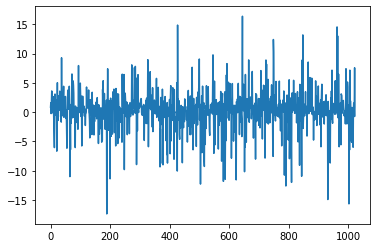

In [84]:
# dataset[['v0', 'player_oriented_reward0']].plot()
(dataset.v0 - dataset.player_oriented_reward0).plot()

In [85]:
%matplotlib inline
from scipy.sparse.csgraph import connected_components
import umap
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

In [86]:

raw_embedded_v = np.vstack(dataset.v_mid)
raw_embedded_p = np.vstack(dataset.p_mid)

In [87]:
import sklearn.base
import bhtsne
import numpy as np


class BHTSNE(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):

    def __init__(self, dimensions=2, perplexity=30.0, theta=0.5, rand_seed=-1):
        self.dimensions = dimensions
        self.perplexity = perplexity
        self.theta = theta
        self.rand_seed = rand_seed

    def fit_transform(self, x):
        return bhtsne.tsne(
            x.astype(np.float64), dimensions=self.dimensions, perplexity=self.perplexity, theta=self.theta,
            rand_seed=self.rand_seed)


In [88]:
%%time

print("start umap")
embedding = umap.UMAP().fit_transform(raw_embedded_p)
print("finish umap")

# bntsne = BHTSNE()
# embedding = bntsne.fit_transform(data)
# embedding = umap.UMAP().fit_transform(raw_embedded)
# tsne_model = TSNE(n_components=2)
# embedding = tsne_model.fit_transform(raw_embedded)



start umap
finish umap
CPU times: user 6.61 s, sys: 126 ms, total: 6.73 s
Wall time: 4.51 s


<Figure size 1152x432 with 0 Axes>

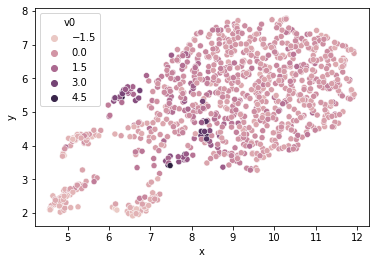

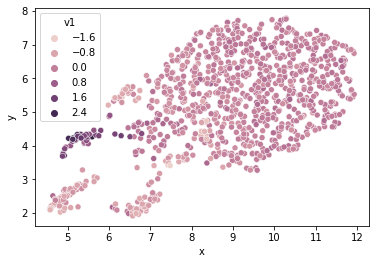

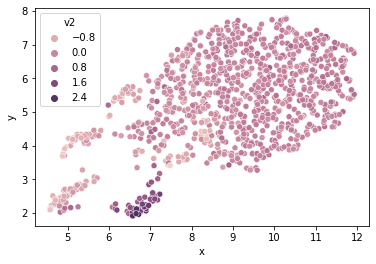

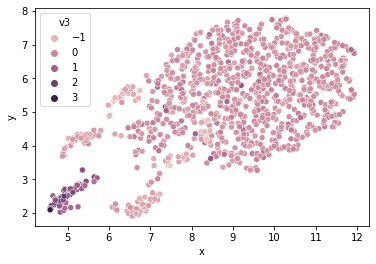

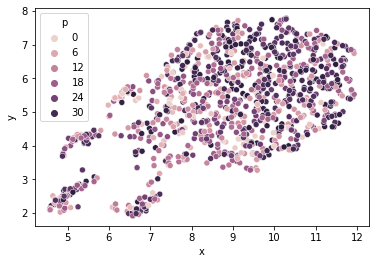

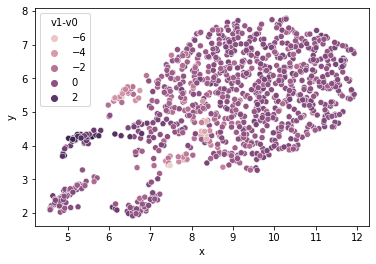

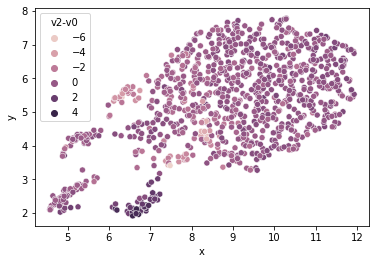

<AxesSubplot:xlabel='x', ylabel='y'>

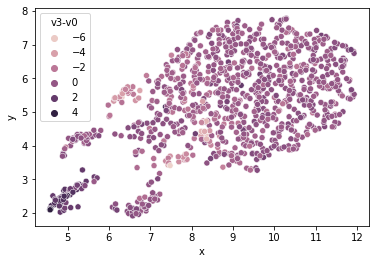

In [89]:

fig = plt.figure(figsize=(16,6))
mark_list = ["o", "+", "s", ">"]
color_list = ["Red", "Blue", "Green", "Black"]
#  for color_id, color in enumerate(colors_list):
cmap = plt.get_cmap("Reds")


key = dataset.game_id.astype(str) + '_' + dataset.kyoku_id.astype(str) + '_' + dataset.player_id.astype(str)
df = pd.DataFrame({
    "x":embedding[:,0],
    "y":embedding[:,1],
    "hue":key,
    "v0":dataset.v0,    
    "v1":dataset.v1,    
    "v2":dataset.v2,    
    "v3":dataset.v3,    
    "p":dataset.p,    
})

fig, ax = plt.subplots()


labels, uniques = pd.factorize(df.hue)
df['labels'] = labels
df['v1-v0'] = df.v1 - df.v0
df['v2-v0'] = df.v2 - df.v0
df['v3-v0'] = df.v3 - df.v0

# #fig.colorbar(mappable)
# plt.legend()
# plt.show()

# for key, group in grouped:
# sns.scatterplot(x='x', y='y', data=df, hue='labels')
sns.scatterplot(x='x', y='y', data=df, hue='v0')
plt.show()
sns.scatterplot(x='x', y='y', data=df, hue='v1')
plt.show()
sns.scatterplot(x='x', y='y', data=df, hue='v2')
plt.show()
sns.scatterplot(x='x', y='y', data=df, hue='v3')
plt.show()
sns.scatterplot(x='x', y='y', data=df, hue='p')


plt.show()
sns.scatterplot(x='x', y='y', data=df, hue='v1-v0')
plt.show()
sns.scatterplot(x='x', y='y', data=df, hue='v2-v0')
plt.show()
sns.scatterplot(x='x', y='y', data=df, hue='v3-v0')

